In [1]:
include("helper.jl")

using DelaunayTriangulation, CairoMakie, DataFrames, CSV, Random, Distributions, .Helper

CairoMakie.activate!()

# Clipped Springerville

 This document provides a quick example of our clipped voronoi methodlogy applied to springerville. This approach uses a method known as Delaunay triangulation to generate the voronoi diagrams. A triangulation is just a way to connect a set of points such that every edge is part of a triangle. There are many descriptions of the Delaunay triagnulation but one of the most intuitive is that it is the triangulation in which every circumcircle of a triangle is an empty circle. In fact conecting the centers of all ahtese cirumscirles is one way to construct the voronoi diagram for a set of points. The triangulations is doubly important because we rely on a triangulation of our convex hull to randomly scatter our random process, over the hull.

### Reading in the vents and constructing the Delaunay Triangulation

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/fyNiH/src/scenes.jl:220


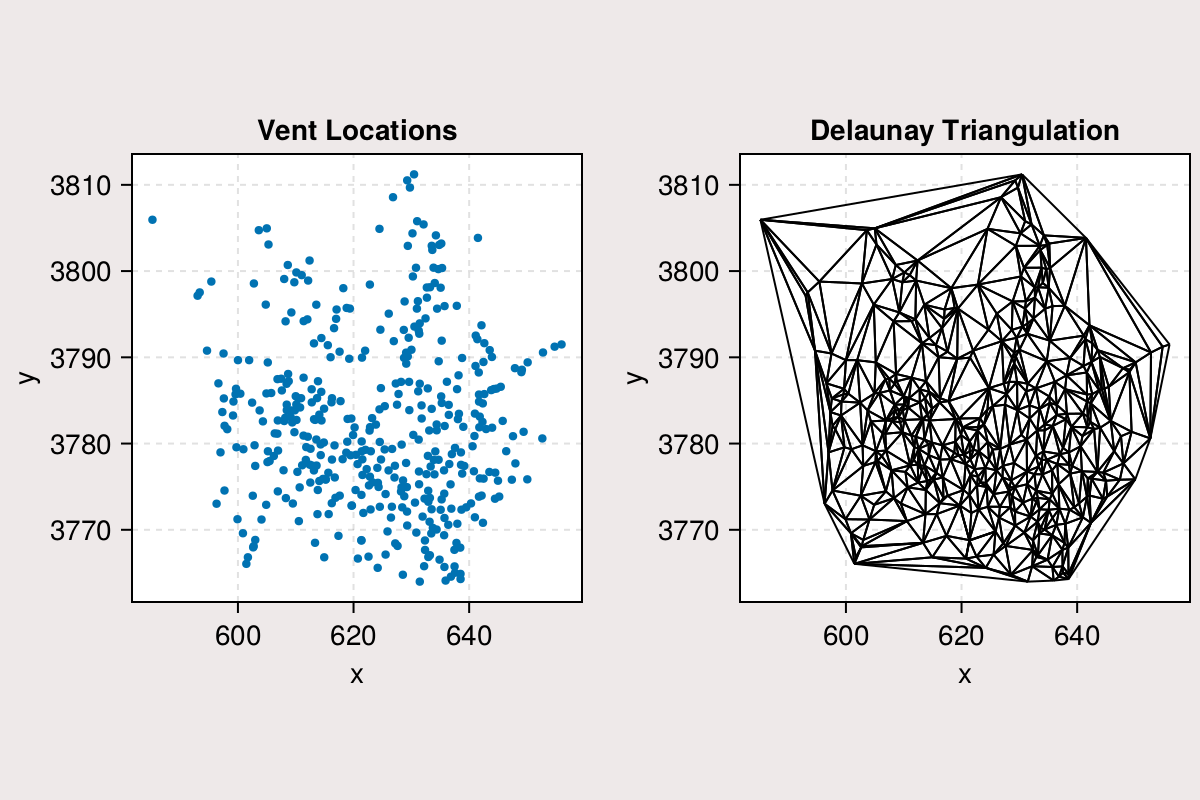

In [2]:
SV = DataFrame(CSV.File("Springerville_Data_UTM.csv"))
X = float.(SV[:,2])./1000
Y = float.(SV[:,3])./1000
N = length(X)

pts = unique([[X[i],Y[i]] for i in 1:N])
N = length(pts)

tri=triangulate(pts)

function fig_triangulate()
    fig = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:snow2,
        resolution=(600,400),
        )
    ax = Axis(fig[1,1];
        xlabel="x",
        ylabel="y",
        title="Vent Locations",
        xgridstyle=:dash,
        ygridstyle=:dash,
        aspect=:true
        )
    scatter!(ax,first.(pts),last.(pts),markersize=6)
    ax = Axis(fig[1,2];
        xlabel="x",
        ylabel="y",
        title="Delaunay Triangulation",
        xgridstyle=:dash,
        ygridstyle=:dash,
        aspect=:true
        )
    triplot!(tri)
    fig
end

fig_triangulate()
#fig, ax, sc = triplot(tri)

Each vent becomes a vertex in the triangulation. Now we identify the points which are part of the convex hull.

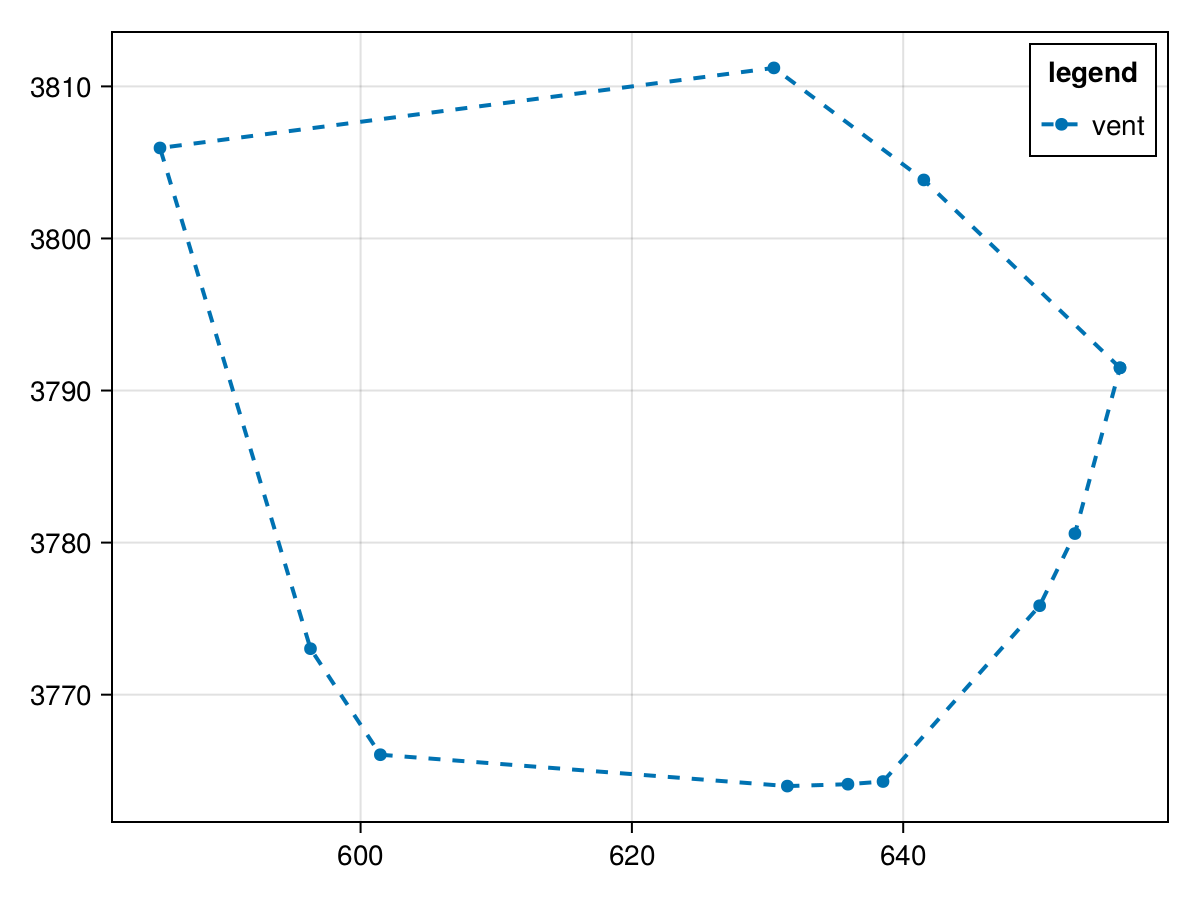

In [3]:
boundary = tri.points[tri.convex_hull.indices]
function fig_convex_hull()
    fig = Figure()
    ax = Axis(fig[1,1])
    scatterlines!(ax, first.(boundary),last.(boundary);
        linewidth=2,
        linestyle=:dash,
        label = "vent",
        )

    axislegend("legend"; position=:rt)
    set_theme!()
    fig
end
fig_convex_hull()


### Randomly scattering points over the convex hull
 Now we need to be able to randomly scatter n points over this convex hull. To do this we use our triangulation and a technique which can randomly scatter points over a triangle. For each point to be randomly scattered, we select a triangle (weighted by its area) and then randomly scatter the point within that triangle. We demonstrate this with 100 and 1000 points.

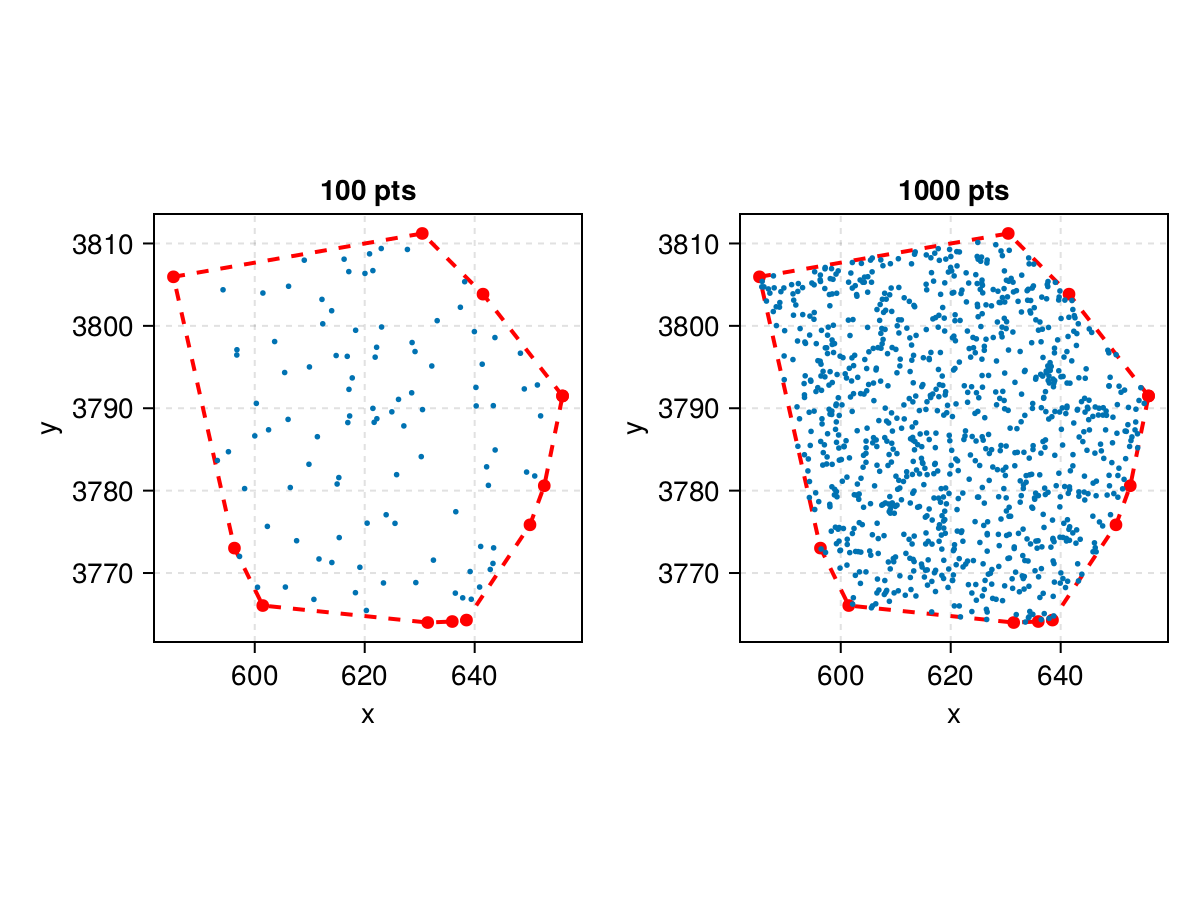

In [4]:
Ws_100 = scatter_over_hull(tri,100)
Ws_1000 = scatter_over_hull(tri,1000)

function fig_scatter_over_hull()
    fig = Figure()
    ax = Axis(fig[1,1];
        xlabel="x",
        ylabel="y",
        title="100 pts",
        xgridstyle=:dash,
        ygridstyle=:dash,
        aspect =:true
        )
    scatterlines!(ax, first.(boundary),last.(boundary);
        color=:red,
        linewidth=2,
        linestyle=:dash,
        label = "boundary",
        )
    scatter!(ax,first.(Ws_100),last.(Ws_100);
        markersize=4,
        label="100 pts")
    
    ax = Axis(fig[1,2];
        xlabel="x",
        ylabel="y",
        title="1000 pts",
        xgridstyle=:dash,
        ygridstyle=:dash,
        aspect = :true
        )
    scatterlines!(ax, first.(boundary),last.(boundary);
        color=:red,
        linewidth=2,
        linestyle=:dash,
        label = "boundary",
        )
    scatter!(ax,first.(Ws_1000),last.(Ws_1000);
        label="1000 pts",
        markersize=4)
    
    set_theme!()
    fig
end

fig_scatter_over_hull()
    
    

### Generating our Voronoi tesselations

We are now ready to generate our voronoi tesselations. We generate the tesselation from our SV vents, and then randomly scatter points over the convex hull of our tesselation to calculate  a residual. Remember the expected number of points to fall in each voronoi cell is one. We color code each voronoi cell by its residual. Results are shown for scattering the random points over a rectangle and over just the convex hull.

In [5]:
vorn = voronoi(tri)
vorn_clip = voronoi(tri, true)

x_min = minimum(X)
x_max = maximum(X)
y_min = minimum(Y)
y_max = maximum(Y);

In [6]:
#=
Setting up simmulation
=#
#setting up cdfs and pdfs for our uniformally distributed

cdf_X_u = zeros(1000)
cdf_Y_u = zeros(1000)
pdf_X_u = zeros(1000)
pdf_Y_u = zeros(1000)

#these denote our rectangular bounding box variables
cdf_X_r_u = zeros(1000)
cdf_Y_r_u = zeros(1000)
pdf_X_r_u = zeros(1000)
pdf_Y_r_u = zeros(1000)

N_sims = 5000
N = length(pts)

Gs = Array{Float64}(undef,N,N_sims)
Gs_r = Array{Float64}(undef,N,N_sims)
ns = rand(Poisson(N),N_sims)

for i in 1:N_sims
    global cdf_X_u, cdf_Y_u, pdf_X_u, pdf_Y_u,cdf_X_u, cdf_Y_u, pdf_X_u, pdf_Y_u, tri

    #======
    Generating our H₀: scattering n points randomly over a convex hull and a rect
    =======#
    n = ns[i]
    Ws = scatter_over_hull(tri,n)
    X_u = first.(Ws)
    Y_u = last.(Ws)
    pts_u = unique([[X_u[i],Y_u[i]] for i in 1:n])
    tri_u = triangulate(pts_u)

    #Rectangular version
    X_r_u = rand(Uniform(x_min,x_max),n)
    Y_r_u = rand(Uniform(y_min,y_max),n)
    pts_r_u = unique([[X_r_u[i],Y_r_u[i]] for i in 1:n])
    tri_r_u = triangulate(pts_r_u)
    
    
    #=======
    Calculating the areas of the voronoi cells created by our H₀ for both clipped
    and rect
    ========#
    vorn_u = voronoi(tri_u,true) 
    areas_u = calc_areas(vorn_u)
    temp_x,temp_y = voronoi_area_cdf(areas_u)
    cdf_X_u += temp_x
    cdf_Y_u += temp_y
    temp_x_p, temp_y_p = voronoi_area_pdf(areas_u)
    pdf_X_u += temp_x_p
    pdf_Y_u += temp_y_p

    #rectangular version
    vorn_r_u = voronoi(tri_r_u,true) 
    areas_r_u = calc_areas(vorn_r_u)
    temp_x,temp_y = voronoi_area_cdf(areas_r_u)
    cdf_X_r_u += temp_x
    cdf_Y_r_u += temp_y
    temp_x_p, temp_y_p = voronoi_area_pdf(areas_r_u)
    pdf_X_r_u += temp_x_p
    pdf_Y_r_u += temp_y_p

    #====
    Now we count how many pts end up in each of our original tesselation
    =====#
    G = find_homes(pts_u,pts)
    Gs[:,i] = G

    #rect
    G_r = find_homes(pts_r_u,pts)
    Gs_r[:,i] = G_r
    
end


#Normalizing our data
cdf_X_u = cdf_X_u ./ N_sims
cdf_Y_u = cdf_Y_u ./ N_sims 
#rect
cdf_X_r_u = cdf_X_r_u ./ N_sims
cdf_Y_r_u = cdf_Y_r_u ./ N_sims 

pdf_X_u = pdf_X_u ./ N_sims
pdf_Y_u = pdf_Y_u ./ N_sims;
#rect
pdf_X_r_u = pdf_X_r_u ./ N_sims
pdf_Y_r_u = pdf_Y_r_u ./ N_sims;

In [7]:
# It is important to note that julia uses θ = 1/shape parameter as its input
gamma = Gamma(3.569,(1/3.569)) #distribution of voronoi cell area for homogenous pp

Gamma{Float64}(α=3.569, θ=0.2801905295601009)

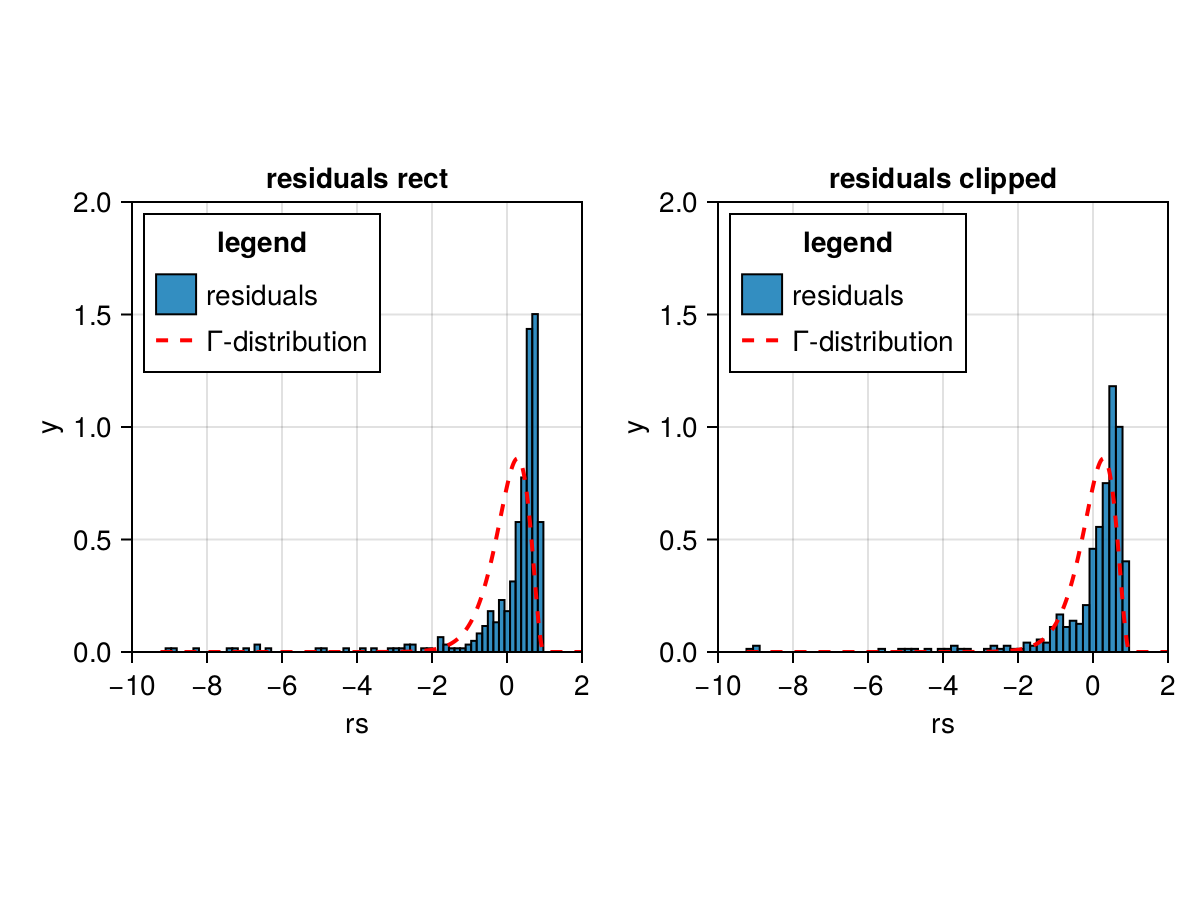

In [8]:
##Residuals
G = mean(Gs,dims=2)
rs = 1 .- G

#rect
G_r = mean(Gs_r,dims=2)
rs_r = 1 .- G_r


#==
Quickly adding the actual gamma distribution to the plot for comparison
==#

gamma_x = collect(range(minimum(rs),2,length=1000))
gamma_y= pdf.(gamma,1 .- gamma_x)

#rect
gamma_x_r = collect(range(minimum(rs),2,length=1000))
gamma_y_r = pdf.(gamma,1 .- gamma_x)


#calc bin nums
sorted_rs = sort(vec(rs))
Q1 = quantile(sorted_rs, 0.25)
Q3 = quantile(sorted_rs, 0.75)

#rect
sorted_rs_r = sort(vec(rs_r))
Q1_r = quantile(sorted_rs_r, 0.25)
Q3_r = quantile(sorted_rs_r, 0.75)

# Calculate the interquartile range (IQR)
iqr = Q3 - Q1
#rect
iqr_r = Q3_r - Q1_r


num_bins = convert(Int,round((maximum(rs) - minimum(rs)) / (2 * iqr / length(rs)^(1/3))))
#rect
num_bins_r = convert(Int,round((maximum(rs_r) - minimum(rs_r)) / (2 * iqr_r / length(rs_r)^(1/3))))

function hist_resids(x,y)
        fig = Figure()
    ax = Axis(fig[1,1];
        xlabel="rs",
        ylabel="y",
        title="residuals rect",
        aspect=:true
        )
    hist!(ax,vec(x);
        normalization =:pdf,
        label="residuals",
        strokewidth = 1, 
        strokecolor = :black,
        bins=round(num_bins_r)
            )
    lines!(ax, gamma_x_r, gamma_y_r;
        linewidth=2,
        linestyle=:dash,
        label = "Γ-distribution",
        color = :red
        )
    limits!(-10, 2, 0, 2)
    axislegend("legend"; position=:lt)

    ax = Axis(fig[1,2];
        xlabel= "rs",
        ylabel= "y",
        title = "residuals clipped",
        aspect = :true 
        )
    hist!(ax,vec(y);
        normalization =:pdf,
        label="residuals",
        strokewidth = 1, 
        strokecolor = :black,
        bins=round(num_bins)
            )
    lines!(ax, gamma_x, gamma_y;
        linewidth=2,
        linestyle=:dash,
        label = "Γ-distribution",
        color = :red
        )
    limits!(-10, 2, 0, 2)
    axislegend("legend"; position=:lt)

    
    save("sv_hist_clipped.png",fig)
    fig
end #function

hist_resids(rs_r,rs)

The results are not surprising, while both cases indicate a departure from random, we see that the results are less extreme over the convex hull. As expected the effects of the boundary of the rectangular box produced the most extreme cells. Finally we visualize these voronoi diagrams and color code them by the residual charts shown above

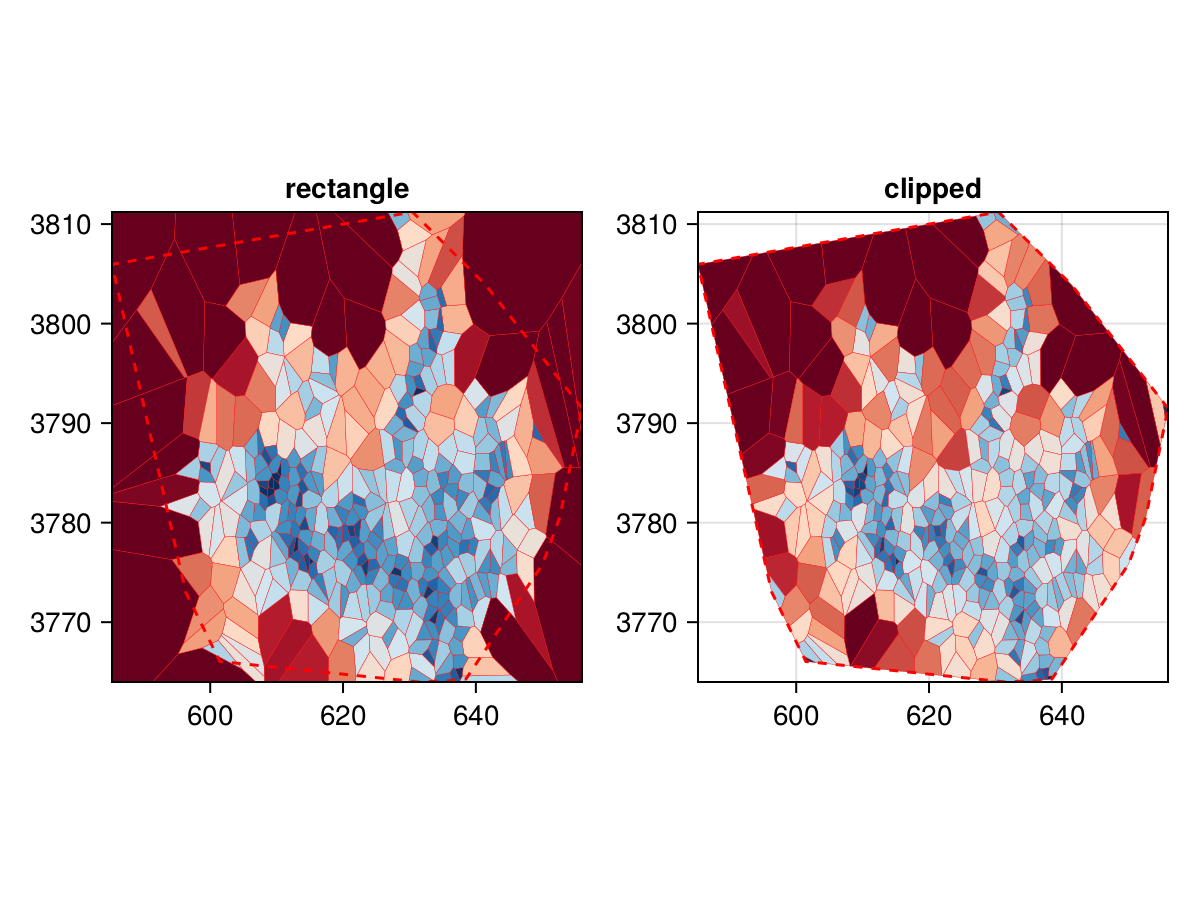

In [9]:
#===========
Now we are going tot ry and recreate the voronoi plots colored by area
============#

#=
First we try to build a color scale around the inverse normal transform
=#

#This is our P-value under the modified gamma distribution
Ps_r = 1 .- cdf.(gamma,G)
#rect
Ps_r_r = 1 .- cdf.(gamma,G_r)

#Now we do a normal transorm with mean and variance coming from our modified gamma 
μ_r = mean(gamma_y)
σ_r = std(gamma_y)
#rect
μ_r_r = mean(gamma_y_r)
σ_r_r = std(gamma_y_r)

#because we have some extreme outliers we want to bound our colorsheme to ± 3σ
ub = μ_r +3*σ_r
lb = μ_r - (3*σ_r)
colorrange=[lb,ub]
#rect
ub_r = μ_r_r +3*σ_r_r
lb_r = μ_r_r - (3*σ_r_r)
colorrange_r=[lb_r,ub_r]

color_dist_r = quantile.(Distributions.Normal(μ_r,σ_r),Ps_r)
#rect
color_dist_r_r = quantile.(Distributions.Normal(μ_r_r,σ_r_r),Ps_r_r)
cmap=:RdBu_10

for i in 1:size(color_dist_r)[1]
    element = color_dist_r[i]
    color_dist_r[i] = min(ub,element)
    color_dist_r[i] = max(lb,element)
end
#rect
for i in 1:size(color_dist_r_r)[1]
    element = color_dist_r_r[i]
    color_dist_r_r[i] = min(ub_r,element)
    color_dist_r_r[i] = max(lb_r,element)
end

#colors = get(cgrad(cmap), color_dist_r)

fig = Figure()
ax = Axis(fig[1, 1], title = "rectangle", aspect=:true)
voronoiplot!(ax, vorn, 
    color=color_dist_r_r,
    colorrange=colorrange_r,
    colormap=cmap,
    strokecolor=:red, 
    strokewidth=0.2, 
    show_generators=false)
triplot!(ax, tri, strokewidth=0.0, strokecolor=(:black, 0.4), show_convex_hull=true)
xlims!(ax, x_min, x_max)
ylims!(ax, y_min, y_max)


ax = Axis(fig[1, 2],title="clipped", aspect=:true)
voronoiplot!(ax, vorn_clip,
    color=color_dist_r,
    colorrange=colorrange,colormap=cmap,
    strokecolor=:red, 
    strokewidth=0.2, 
    show_generators=false)
triplot!(ax, tri, strokewidth=0.0, strokecolor=(:black, 0.4), show_convex_hull=true)
xlims!(ax, x_min, x_max)
ylims!(ax, y_min, y_max)
fig

#save("sv_color_compare.png",fig)
#areas_clipped = calc_areas(vorn_clip)
#voronoiplot(vorn,show_generators=false,color=color_dist_r, colorrange=[lb,ub],colormap=cmap)


As expected from the residual plots, the structure is very similar, but less extreme. This is most easily seen by the lack of darkest blue in the center. Also many of the cells along the bottom half of the convex hull are colored quite differently, because they become smaller once clipped and should contain fewer points.

Finally we look at our intesection point plots.

### Areal CDFs and PDFs

For this section we cannot do an immediate direct comparrison to the old methodlogy because, this technique marks the voronoi cells on the boundaries as open (they do not have an area). However we can compare the difference between simmulating the random process over a rectangle and a convex hull. In both cases our observed PDFs and CDFs are calculated from the clipped tesselation. In other words we can see how the boundary effects our null hypothesis, to compare the final results we can just compare the intersection points generated here to those from our old method

In [10]:
areas = get_area.(Ref(vorn_clip), 1:num_polygons(vorn_clip))
cdf_X,cdf_Y = voronoi_area_cdf(areas;res=.001)
pdf_X,pdf_Y = voronoi_area_pdf(areas;res=.075)
#smooth_X,smooth_Y = voronoi_area_smooth(areas);
pushfirst!(cdf_X,0)
pushfirst!(cdf_Y,0);

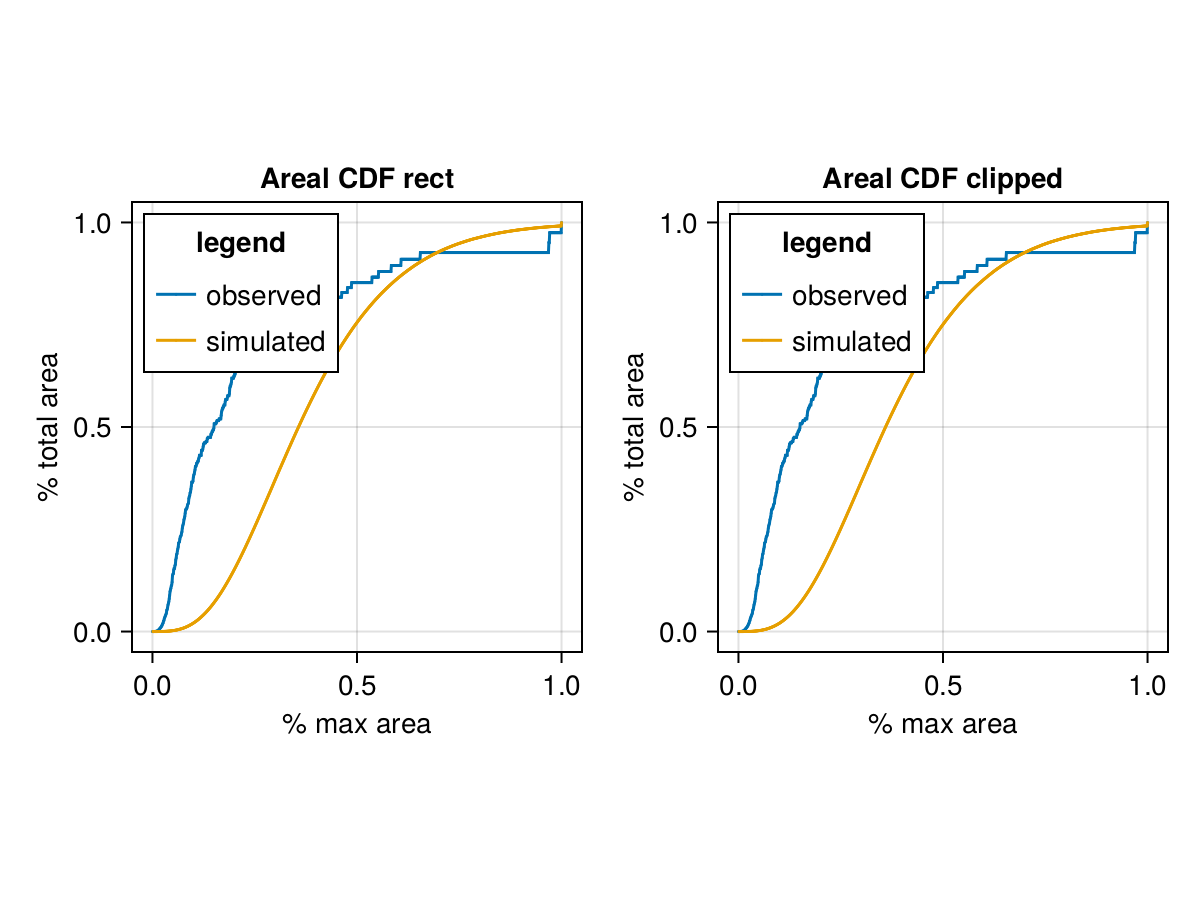

In [11]:
function area_cdf_compare()
        fig = Figure()
    ax = Axis(fig[1,1];
        xlabel="% max area",
        ylabel="% total area",
        title="Areal CDF rect",
        aspect=:true
        )
    scatterlines!(cdf_X,cdf_Y,markersize=2,
        label="observed")
     scatterlines!(cdf_X_r_u,cdf_Y_r_u,markersize=2,
        label="simulated")
  
    axislegend("legend"; position=:lt)
    save("sv_hist_clipped.png",fig)

    ax = Axis(fig[1,2];
        xlabel="% max area",
        ylabel="% total area",
        title="Areal CDF clipped",
        aspect=:true
        )
    scatterlines!(cdf_X,cdf_Y,markersize=2,
        label="observed")
     scatterlines!(cdf_X_u,cdf_Y_u,markersize=2,
        label="simulated")
  
    axislegend("legend"; position=:lt)
    save("sv_hist_clipped.png",fig)
    
    fig
end #function

area_cdf_compare()

We see no discernable differencce in these plots. This is interesting and suggests that the distribution of cell sizes created by a random scattering of points is independent of boundary geometry. We expect the biggest difference of using the convex hull approach to appear in the observed areal PDF and CDF. As mentioned above the different packages used in both make a direct comparrisonn within the same notebook different. However, I will display an image of the SV pdf from our old notebook side by side with the PDF generated from this one. 

In [12]:
#=
 RUN ONLY ONCE prepairing pdf plots
=#
pushfirst!(pdf_X,0)
pushfirst!(pdf_Y,0);

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/fyNiH/src/scenes.jl:220


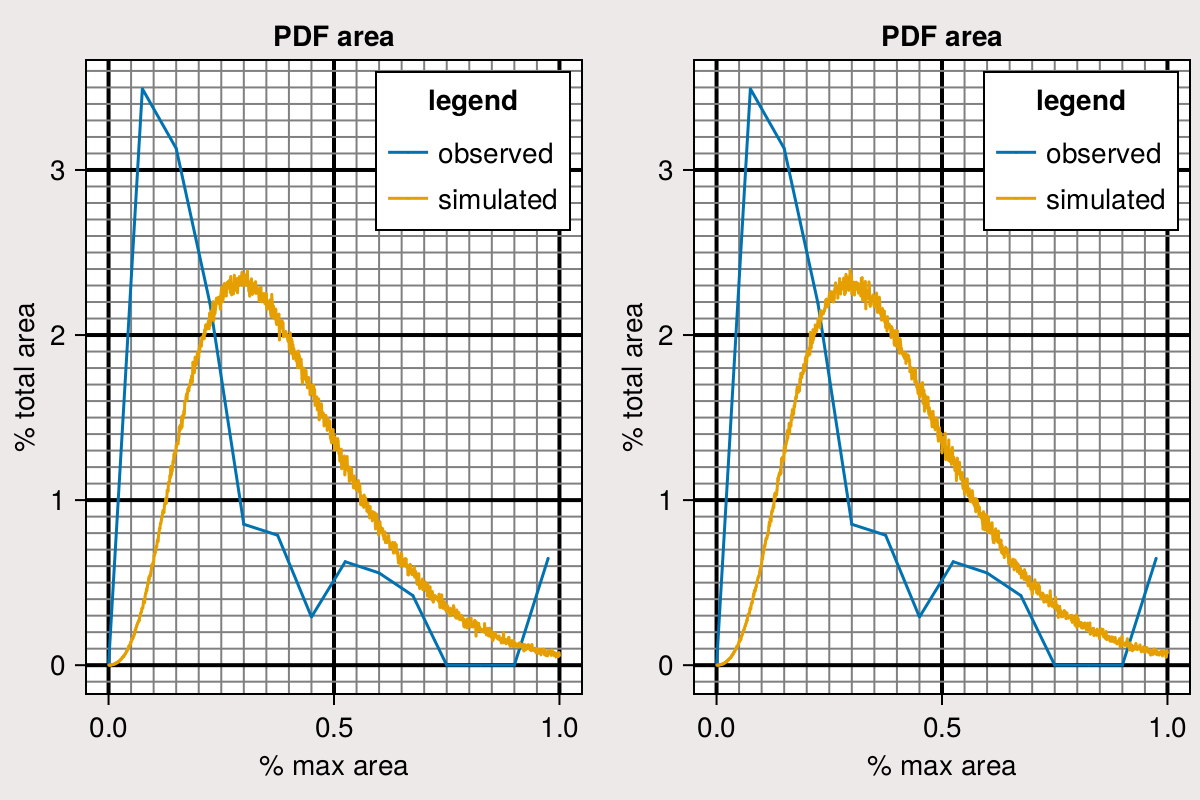

In [13]:
function area_pdf_compare()
        fig = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:snow2,
        resolution=(600,400),
        )
    ax = Axis(fig[1,1];
        xlabel="% max area",
        ylabel="% total area",
        title="PDF area",
        xgridcolor = :black,
        ygridcolor = :black,
        xgridwidth = 2,
        ygridwidth = 2,
        xminorgridcolor = :grey,
        yminorgridcolor = :grey,
        xminorgridvisible = true,
        yminorgridvisible = true,
        xminorticks = IntervalsBetween(10),
        yminorticks = IntervalsBetween(10)
        )
    scatterlines!(pdf_X,pdf_Y,markersize=2,
        label="observed")
     scatterlines!(pdf_X_r_u,pdf_Y_r_u,markersize=2,
        label="simulated")
  
    axislegend("legend"; position=:rt)

    ax = Axis(fig[1,2];
        xlabel="% max area",
        ylabel="% total area",
        title="PDF area",
        xgridcolor = :black,
        ygridcolor = :black,
        xgridwidth = 2,
        ygridwidth = 2,
        xminorgridcolor = :grey,
        yminorgridcolor = :grey,
        xminorgridvisible = true,
        yminorgridvisible = true,
        xminorticks = IntervalsBetween(10),
        yminorticks = IntervalsBetween(10)
        )
    scatterlines!(pdf_X,pdf_Y,markersize=2,
        label="observed")
     scatterlines!(pdf_X_u,pdf_Y_u,markersize=2,
        label="simulated")
  
    axislegend("legend"; position=:rt)
    #save("sv_pdf_clipped.png",fig)
    fig
end #function

area_pdf_compare()

![alternative text](compare_pdf.png)

We notice that the peak is less extreme and the intersection point happens later. To find the exact difference in lengthscale we would need to un-normalize these results, but that is the final step. I hope this was a good overview for how the methodology was changed to address some boundary conditions concers.

In [14]:
max_area = maximum(calc_areas(vorn_clip))
xing= 0.23

0.23

intersection looks like it happens at 23% max area soo...

In [15]:
critical_area = xing*max_area
critical_length = sqrt(critical_area)
critical_radius = critical_length/π

println(critical_area)
println(critical_length)
println(critical_radius)


14.185957754438277
3.7664250628996028
1.1988903330913492


In [16]:
tri.points[get_convex_hull_indices(tri)]

12-element Vector{Vector{Float64}}:
 [655.981, 3791.493]
 [641.517, 3803.848]
 [630.468, 3811.215]
 [585.214, 3805.951]
 [596.308, 3773.024]
 [601.457, 3766.052]
 [631.459, 3763.989]
 [635.928, 3764.112]
 [638.512, 3764.289]
 [650.059, 3775.85]
 [652.658, 3780.594]
 [655.981, 3791.493]